In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error

# 1. Chargement du dataset
df = pd.read_csv("Steel_industry_data.csv")


In [13]:
# 2. Feature Engineering (On rend la date exploitable)
# Le format dans ce dataset est souvent Jour/Mois/Année Heure:Minute
df['date'] = pd.to_datetime(df['date'], dayfirst=True)
df['hour'] = df['date'].dt.hour
df['day_of_week'] = df['date'].dt.dayofweek
df['month'] = df['date'].dt.month


C:\Users\anton\AppData\Local\Temp\ipykernel_19540\3490850014.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df, x='WeekStatus', y='Usage_kWh', palette='viridis')


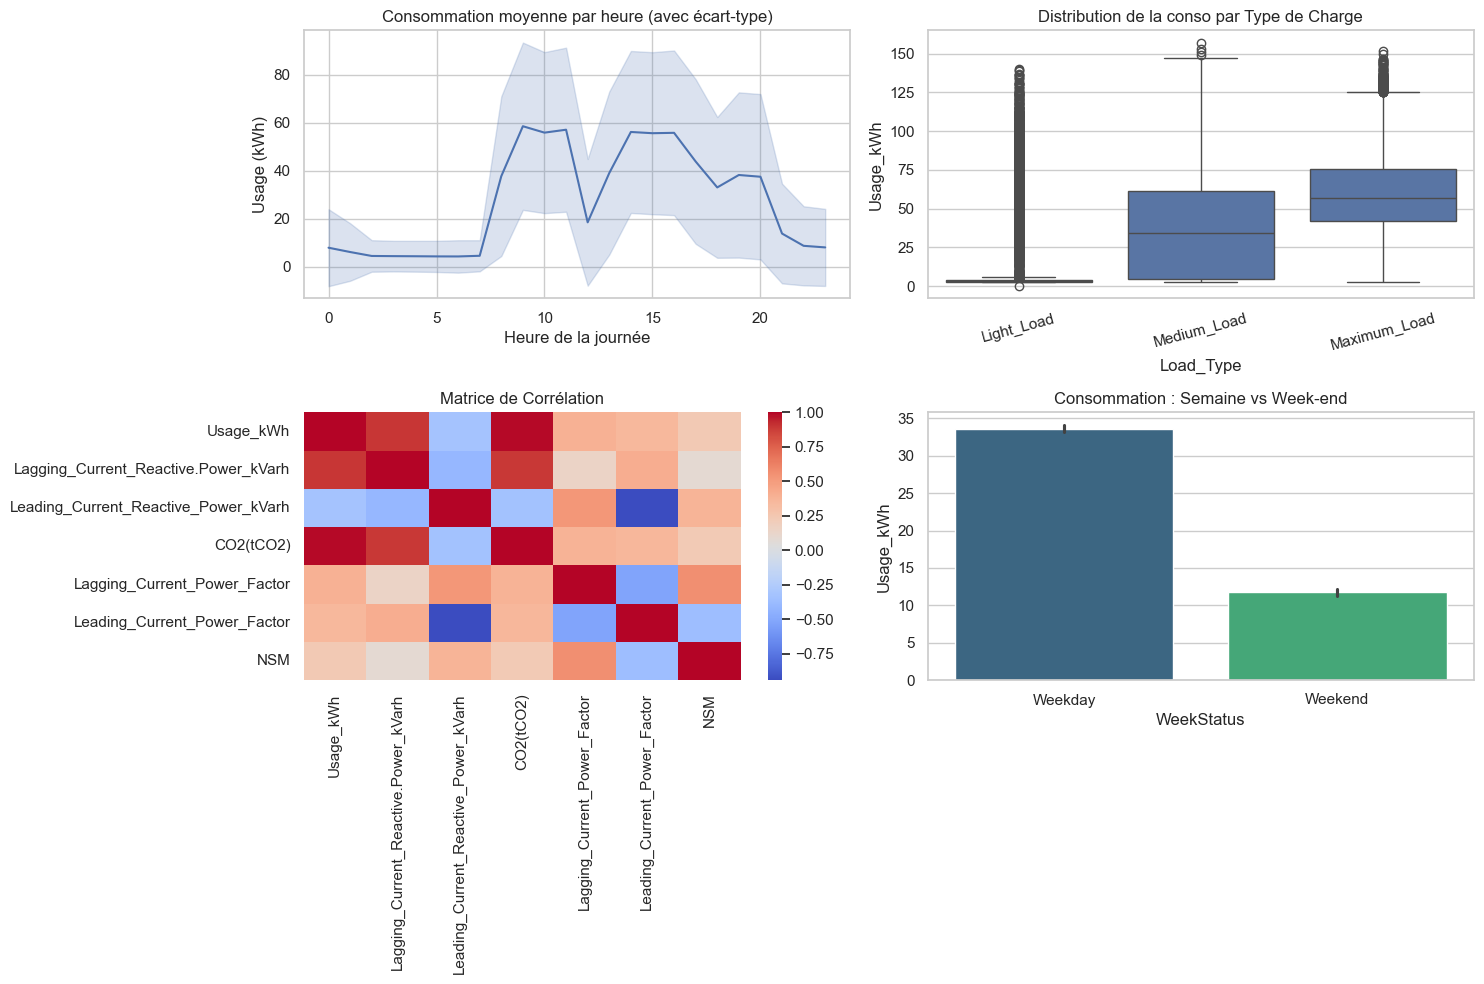

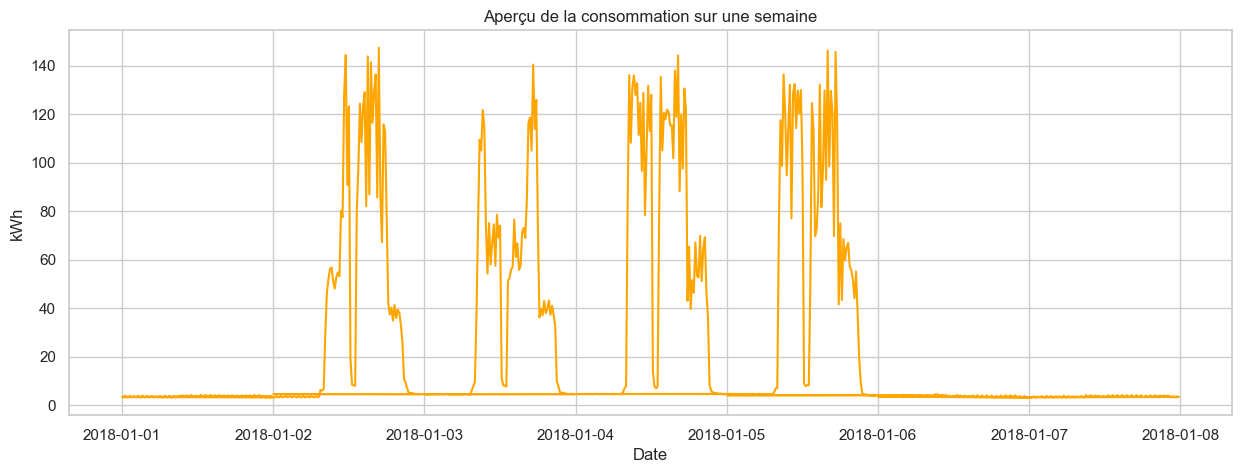

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configurer le style des graphes
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))

# --- GRAPHE 1 : La consommation sur 24h (L'effet "Shift" de l'usine) ---
plt.subplot(2, 2, 1)
sns.lineplot(data=df, x='hour', y='Usage_kWh', errorbar='sd')
plt.title('Consommation moyenne par heure (avec écart-type)')
plt.xlabel('Heure de la journée')
plt.ylabel('Usage (kWh)')

# --- GRAPHE 2 : Boxplot par type de charge (Pour voir les outliers) ---
plt.subplot(2, 2, 2)
sns.boxplot(data=df, x='Load_Type', y='Usage_kWh')
plt.title('Distribution de la conso par Type de Charge')
plt.xticks(rotation=15)

# --- GRAPHE 3 : Heatmap de Corrélation (Qu'est-ce qui influence la conso ?) ---
plt.subplot(2, 2, 3)
# On ne garde que les colonnes numériques pour la corrélation
numeric_df = df.select_dtypes(include=['float64', 'int64'])
sns.heatmap(numeric_df.corr(), annot=False, cmap='coolwarm')
plt.title('Matrice de Corrélation')

# --- GRAPHE 4 : Conso Semaine vs Week-end ---
plt.subplot(2, 2, 4)
sns.barplot(data=df, x='WeekStatus', y='Usage_kWh', palette='viridis')
plt.title('Consommation : Semaine vs Week-end')

plt.tight_layout()
plt.show()

# --- BONUS : La conso sur une semaine complète (Timeline) ---
plt.figure(figsize=(15, 5))
sample_week = df.head(24 * 7 * 4) # On prend les 4 premières mesures par heure sur 7 jours
plt.plot(sample_week['date'], sample_week['Usage_kWh'], color='orange')
plt.title('Aperçu de la consommation sur une semaine')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.show()

In [15]:
# 3. Séparation Features (X) et Cible (y)
# On prédit la consommation en kWh
y = df['Usage_kWh']

# On sélectionne les colonnes pertinentes (on vire la date brute et le target)
X = df.drop(columns=['date', 'Usage_kWh'])

# 4. Préparation du Preprocessing
# Colonnes catégorielles à encoder (le statut de la semaine et le jour)
cat_features = ['WeekStatus', 'Day_of_week', 'Load_Type']
# Colonnes numériques à scaler
num_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_features = [f for f in num_features if f not in cat_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

# 5. Pipeline complet : Preprocessing + Modèle
# On utilise RandomForest car c'est robuste pour les données tabulaires
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])


Lancement de l'entraînement... ça peut prendre un peu de temps.
R2 Score: 0.9990
MAE: 0.34 kWh
MSE: 1.12 kWh²


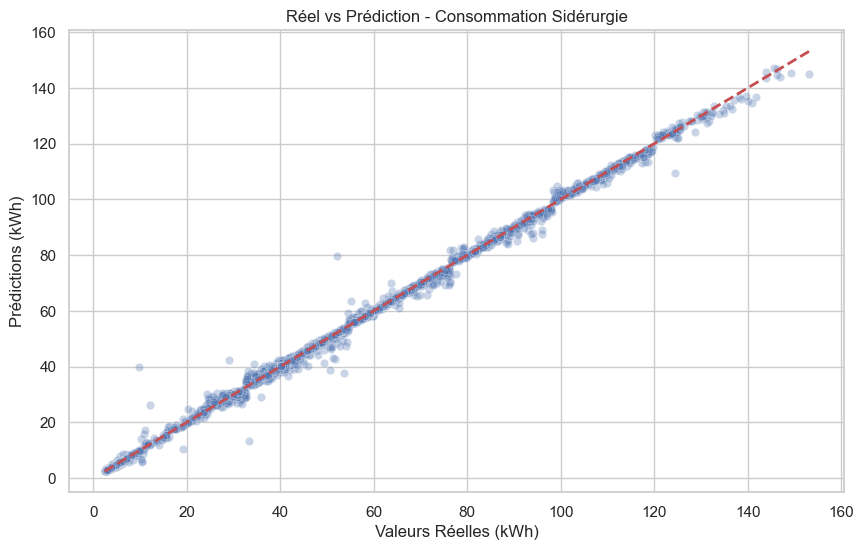

In [16]:

# 6. Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Entraînement
print("Lancement de l'entraînement... ça peut prendre un peu de temps.")
model_pipeline.fit(X_train, y_train)

# 8. Évaluation
y_pred = model_pipeline.predict(X_test)
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f} kWh")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f} kWh²")

# 9. Visualisation des résultats (Optionnel mais recommandé pour les apprenants)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
plt.xlabel('Valeurs Réelles (kWh)')
plt.ylabel('Prédictions (kWh)')
plt.title('Réel vs Prédiction - Consommation Sidérurgie')
plt.show()

- R2 Score: 0.9990
- MAE: 0.34 kWh
- MSE: 1.12 kWh²

Pas possible

In [17]:
df.columns

Index(['date', 'Usage_kWh', 'Lagging_Current_Reactive.Power_kVarh',
       'Leading_Current_Reactive_Power_kVarh', 'CO2(tCO2)',
       'Lagging_Current_Power_Factor', 'Leading_Current_Power_Factor', 'NSM',
       'WeekStatus', 'Day_of_week', 'Load_Type', 'hour', 'day_of_week',
       'month'],
      dtype='str')

Lancement de l'entraînement... ça peut prendre un peu de temps.
R2 Score: 0.7005
MAE: 10.61 kWh
MSE: 340.48 kWh²


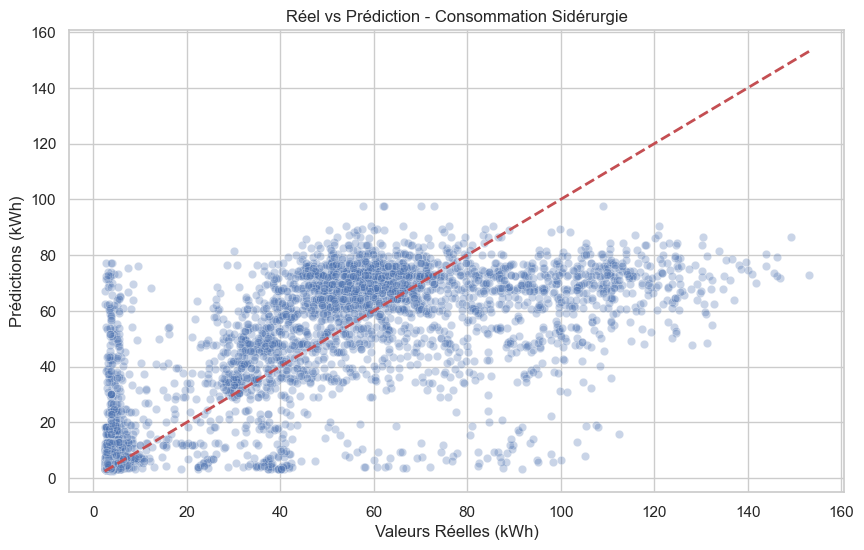

In [18]:
# 3. Séparation Features (X) et Cible (y)
# On prédit la consommation en kWh
y = df['Usage_kWh']

# On ne garde que ce qui est "prédictible" à l'avance
X = df[['NSM', 'WeekStatus', 'Day_of_week', 'Load_Type', 'hour']]

# 4. Préparation du Preprocessing
# Colonnes catégorielles à encoder (le statut de la semaine et le jour)
cat_features = ['WeekStatus', 'Day_of_week', 'Load_Type']
# Colonnes numériques à scaler
num_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
num_features = [f for f in num_features if f not in cat_features]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), num_features),
        ('cat', OneHotEncoder(), cat_features)
    ])

# 5. Pipeline complet : Preprocessing + Modèle
# On utilise RandomForest car c'est robuste pour les données tabulaires
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# 6. Split Train/Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 7. Entraînement
print("Lancement de l'entraînement... ça peut prendre un peu de temps.")
model_pipeline.fit(X_train, y_train)

# 8. Évaluation
y_pred = model_pipeline.predict(X_test)
print(f"R2 Score: {r2_score(y_test, y_pred):.4f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f} kWh")
print(f"MSE: {mean_squared_error(y_test, y_pred):.2f} kWh²")

# 9. Visualisation des résultats (Optionnel mais recommandé pour les apprenants)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--r', lw=2)
plt.xlabel('Valeurs Réelles (kWh)')
plt.ylabel('Prédictions (kWh)')
plt.title('Réel vs Prédiction - Consommation Sidérurgie')
plt.show()